# Movie Recommendation System

This notebook builds a **content-based movie recommender** using the TMDB 5000 dataset.

**What you’ll find here**
- Data loading that works with local files
- Careful preprocessing and feature engineering
- A content-based similarity model (CountVectorizer + Cosine Similarity)
- Reusable `recommend(title, n)` function
- Visualizations: top genres, movie popularity, similarity distribution


## 1) Setup


In [ ]:
# !pip install pandas numpy scikit-learn matplotlib

## 2) Importing Libraries

In [2]:
import os
import re
import ast
import json
import math
import pickle
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Display settings for readability
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

# Matplotlib defaults for clean visuals
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True


## 3) Data Paths


In [3]:
# Try common local filenames first; edit these if needed.
DATA_PATHS = {
    "movies": "/content/drive/MyDrive/Colab Notebooks/Elevvo/tmdb_5000_movies.csv",
    "credits": "/content/drive/MyDrive/Colab Notebooks/Elevvo/tmdb_5000_credits.csv",
}

# Validate existence and give a helpful message
for k, p in DATA_PATHS.items():
    if not os.path.exists(p):
        print(f"[Info] Could not find '{p}' in current directory. If you have the files elsewhere, set DATA_PATHS['{k}'] to the full path.")

## 4) Load Data

We use the widely known **TMDB 5000** dataset (two CSVs: movies & credits).


In [4]:
def load_tmdb(paths: dict) -> pd.DataFrame:
    """Load the TMDB 5000 movies + credits and return a merged DataFrame.

    Returns columns: id, title, genres, keywords, overview, cast, crew, original_language, vote_count, vote_average, popularity
    """
    movies = pd.read_csv(paths['movies'])
    credits = pd.read_csv(paths['credits'])

    # Basic sanity checks
    assert {'id', 'title', 'genres', 'keywords', 'overview', 'original_language', 'vote_count', 'vote_average', 'popularity'}.issubset(movies.columns), \
        'Movies CSV missing required columns.'
    assert {'movie_id', 'title', 'cast', 'crew'}.issubset(credits.columns), 'Credits CSV missing required columns.'

    df = movies.merge(credits, left_on='id', right_on='movie_id', how='inner', suffixes=('', '_cred'))
    return df

# Attempt load with helpful error messages
try:
    df_raw = load_tmdb(DATA_PATHS)
    print(f'Loaded {len(df_raw):,} rows. Columns: {list(df_raw.columns)[:12]}...')
except FileNotFoundError as e:
    raise FileNotFoundError('CSV files not found. Please place tmdb_5000_movies.csv and tmdb_5000_credits.csv alongside this notebook or update DATA_PATHS.') from e


Loaded 4,803 rows. Columns: ['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date']...


## 5) Quick EDA (Exploratory Data Analysis)

We’ll check basic structure and peek at a few rows to understand the data.


In [5]:
display(df_raw.head(3))
display(df_raw[['title', 'overview', 'genres', 'keywords', 'cast', 'crew']].sample(3, random_state=42))
print(df_raw.isna().mean().sort_values(ascending=False).head(10))

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,title_cred,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 33...",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn bet...",150.44,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporation"", ""id"": 306}, {""na...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.20,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""credit_id"": ""5602a8a7c3a3685532001c9a"", ""gender"": 2, ""id"": 65731, ""nam...","[{""credit_id"": ""52fe48009251416c750aca23"", ""department"": ""Editing"", ""gender"": 0, ""id"": 1721, ""job"": ""Editor"", ""name""..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic island""}, {""id"": 1319,...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will T...",139.08,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""name"": ""Jerry Bruckheimer Films"", ""id"": 130}, {""name"": ""Second Mate Pr...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.90,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Sparrow"", ""credit_id"": ""52fe4232c3a36847f800b50d"", ""gender"": 2, ""id"": 85,...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""department"": ""Camera"", ""gender"": 2, ""id"": 120, ""job"": ""Director of Photo..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 80, ""name"": ""Crime""}]",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name"": ""based on novel""}, {""id"": 4289, ""name"": ""secret agent""}, {""id"": 966...",en,Spectre,A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles politica...,107.38,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""name"": ""Danjaq"", ""id"": 10761}, {""name"": ""B24"", ""id"": 69434}]",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""}, {""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""...",Released,A Plan No One Escapes,Spectre,6.30,4466,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""credit_id"": ""52fe4d22c3a368484e1d8d6b"", ""gender"": 2, ""id"": 8784, ""name"":...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""department"": ""Sound"", ""gender"": 2, ""id"": 153, ""job"": ""Original Music Com..."


,title,overview,genres,keywords,cast,crew
596,I Spy,"When the Switchblade, the most sophisticated prototype stealth fighter created yet, is stolen from the U.S. governme...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 35, ""name"": ""Comedy""}, {""id"": 53, ""name"": ""Th...","[{""id"": 810, ""name"": ""budapest""}, {""id"": 1930, ""name"": ""kidnapping""}, {""id"": 2792, ""name"": ""boxer""}, {""id"": 4289, ""n...","[{""cast_id"": 1, ""character"": ""Kelly Robinson"", ""credit_id"": ""52fe44a7c3a36847f80a27e1"", ""gender"": 2, ""id"": 776, ""nam...","[{""credit_id"": ""52fe44a8c3a36847f80a280d"", ""department"": ""Camera"", ""gender"": 2, ""id"": 11409, ""job"": ""Director of Pho..."
3372,Split Second,"In a futuristic London, the rising sea levels mean that large areas are under feet of water. Hauer plays a cop who p...","[{""id"": 53, ""name"": ""Thriller""}, {""id"": 28, ""name"": ""Action""}, {""id"": 27, ""name"": ""Horror""}, {""id"": 878, ""name"": ""Sc...","[{""id"": 3528, ""name"": ""flooding""}, {""id"": 9685, ""name"": ""futuristic""}, {""id"": 15167, ""name"": ""police detective""}]","[{""cast_id"": 1, ""character"": ""Harley Stone"", ""credit_id"": ""52fe452e9251416c7504e50b"", ""gender"": 2, ""id"": 585, ""name""...","[{""credit_id"": ""57011d5092514106c6004157"", ""department"": ""Production"", ""gender"": 2, ""id"": 1325, ""job"": ""Casting"", ""n..."
2702,Gossip,"On a beautiful college campus, something ugly is about to be spread around. A bit of gossip that was told is startin...","[{""id"": 18, ""name"": ""Drama""}, {""id"": 9648, ""name"": ""Mystery""}, {""id"": 53, ""name"": ""Thriller""}]","[{""id"": 3616, ""name"": ""college""}, {""id"": 9937, ""name"": ""suspense""}, {""id"": 18453, ""name"": ""gossip""}, {""id"": 189868, ...","[{""cast_id"": 1, ""character"": ""Beau Edson"", ""credit_id"": ""52fe475b9251416c7509682b"", ""gender"": 2, ""id"": 11866, ""name""...","[{""credit_id"": ""58f82ecf9251415c5900238a"", ""department"": ""Sound"", ""gender"": 2, ""id"": 5912, ""job"": ""Original Music Co..."


homepage            0.64
tagline             0.18
overview            0.00
runtime             0.00
release_date        0.00
id                  0.00
genres              0.00
budget              0.00
original_title      0.00
original_language   0.00
dtype: float64


## 6) Parsing JSON-like Columns

The TMDB columns `genres`, `keywords`, `cast`, `crew` are JSON-like strings. We'll parse them to extract **names** only. For crew, we’ll specifically extract the **Director**.


In [6]:
import ast

def parse_name_list(s):
    """Parse a list of dicts (as string) and return a list of 'name' values."""
    if pd.isna(s):
        return []
    try:
        items = ast.literal_eval(s)
        if isinstance(items, list):
            return [d.get('name','') for d in items if isinstance(d, dict) and d.get('name')]
    except Exception:
        pass
    return []

def parse_top_n(lst, n=5):
    return lst[:n] if isinstance(lst, list) else []

def extract_director(crew_str):
    if pd.isna(crew_str): return ''
    try:
        crew = ast.literal_eval(crew_str)
        for d in crew:
            if isinstance(d, dict) and d.get('job') == 'Director':
                return d.get('name','')
    except Exception:
        pass
    return ''

df = df_raw.copy()

# Extract lists
df['genres_list'] = df['genres'].apply(parse_name_list)
df['keywords_list'] = df['keywords'].apply(parse_name_list)
df['cast_list'] = df['cast'].apply(parse_name_list).apply(lambda x: parse_top_n(x, 5))

# Extract director
df['director'] = df['crew'].apply(extract_director)

# Clean title for safe matching
df['title_clean'] = df['title'].str.strip().str.lower()

display(df[['title','genres_list','keywords_list','cast_list','director']].head(5))

,title,genres_list,keywords_list,cast_list,director
0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, space, alien, tribe, al...","[Sam Worthington, Zoe Saldana, Sigourney Weaver, Stephen Lang, Michelle Rodriguez]",James Cameron
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india trading company, love of one's life, traitor, shipwreck, strong woman,...","[Johnny Depp, Orlando Bloom, Keira Knightley, Stellan Skarsgård, Chow Yun-fat]",Gore Verbinski
2,Spectre,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi6, british secret service, united kingdom]","[Daniel Craig, Christoph Waltz, Léa Seydoux, Ralph Fiennes, Monica Bellucci]",Sam Mendes
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret identity, burglar, hostage drama, time bomb, gotham city, vigilante, co...","[Christian Bale, Michael Caine, Gary Oldman, Anne Hathaway, Tom Hardy]",Christopher Nolan
4,John Carter,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel, princess, alien, steampunk, martian, escape, edgar rice burroughs, a...","[Taylor Kitsch, Lynn Collins, Samantha Morton, Willem Dafoe, Thomas Haden Church]",Andrew Stanton


## 7) Visualizations

Some quick, informative charts:

- **Top Genres** by frequency

- **Movie Popularity** (distribution of `popularity`)

- **Vote Average** distribution



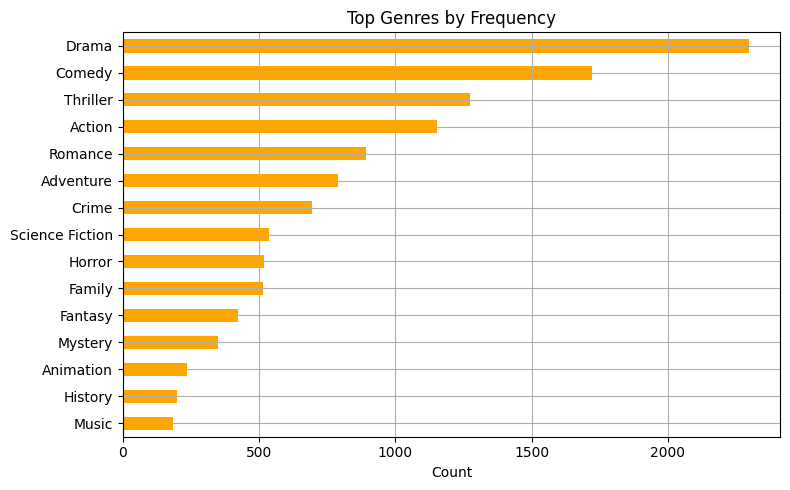

In [10]:
# Top Genres
all_genres = [g for lst in df['genres_list'] for g in lst]
top_genres = pd.Series(all_genres).value_counts().head(15)

plt.figure()
top_genres.sort_values().plot(kind='barh', color = "Orange")
plt.title('Top Genres by Frequency')
plt.xlabel('Count')
plt.tight_layout()
plt.show()


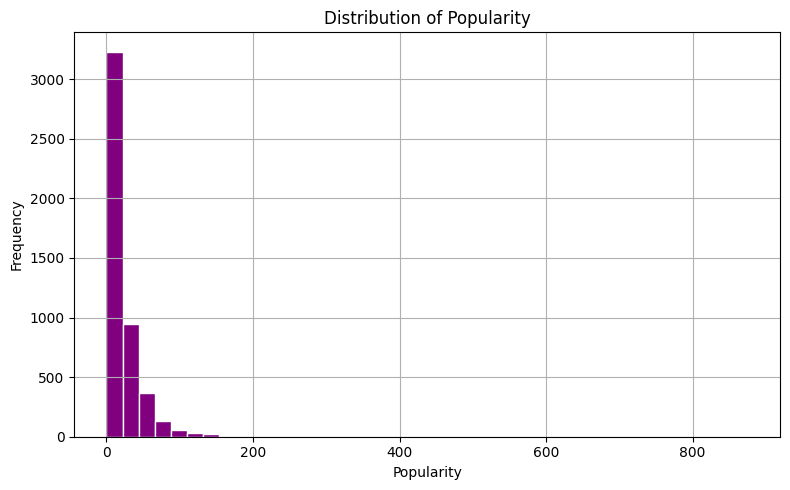

In [17]:
# Popularity distribution
plt.figure()
df['popularity'].dropna().plot(kind='hist', bins=40, color = "Purple", edgecolor= "white")
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

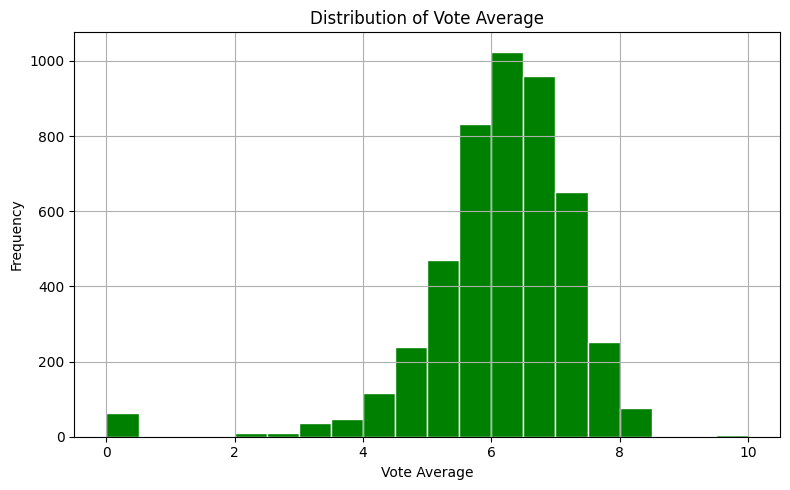

In [21]:
# Vote average distribution
plt.figure()
df['vote_average'].dropna().plot(kind='hist', bins=20, edgecolor= "white", color = "Green")
plt.title('Distribution of Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 8) Feature Engineering: Building a **Tag** Text

We combine multiple signals into a single **text field**:

- `overview` (description)

- Top-5 `cast`

- `director`

- `genres`

- Top-10 `keywords`

This gives the model a rich textual representation per movie.


In [13]:
def clean_token(s):
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(s).lower())
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['overview_clean'] = df['overview'].fillna('').apply(clean_token)
df['genres_clean'] = df['genres_list'].apply(lambda lst: ' '.join([clean_token(x).replace(' ','') for x in lst]))
df['keywords_clean'] = df['keywords_list'].apply(lambda lst: ' '.join([clean_token(x).replace(' ','') for x in lst[:10]]))
df['cast_clean'] = df['cast_list'].apply(lambda lst: ' '.join([clean_token(x).replace(' ','') for x in lst]))
df['director_clean'] = df['director'].apply(lambda x: clean_token(x).replace(' ', ''))

df['tags'] = (df['overview_clean'] + ' ' +
              df['genres_clean'] + ' ' +
              df['keywords_clean'] + ' ' +
              df['cast_clean'] + ' ' +
              df['director_clean']).str.strip()

display(df[['title','tags']].head(5))

,title,tags
0,Avatar,in the 22nd century a paraplegic marine is dispatched to the moon pandora on a unique mission but becomes torn betwe...
1,Pirates of the Caribbean: At World's End,captain barbossa long believed to be dead has come back to life and is headed to the edge of the earth with will tur...
2,Spectre,a cryptic message from bond s past sends him on a trail to uncover a sinister organization while m battles political...
3,The Dark Knight Rises,following the death of district attorney harvey dent batman assumes responsibility for dent s crimes to protect the ...
4,John Carter,john carter is a war weary former military captain who s inexplicably transported to the mysterious and exotic plane...


## 9) Vectorization & Similarity

We use `CountVectorizer` (bag-of-words) limited to the top 10,000 features, remove English stopwords, and compute **cosine similarity**.


In [14]:
vectorizer = CountVectorizer(max_features=10000, stop_words='english')
matrix = vectorizer.fit_transform(df['tags'])  # sparse matrix
similarity = cosine_similarity(matrix)         # dense; may be large in RAM for big datasets

print('Matrix shape:', matrix.shape)
print('Similarity shape:', similarity.shape)

Matrix shape: (4803, 10000)
Similarity shape: (4803, 4803)


## 10) Similarity Distribution (Sanity Check)

We sample some similarity values to get a sense of the model's spread.


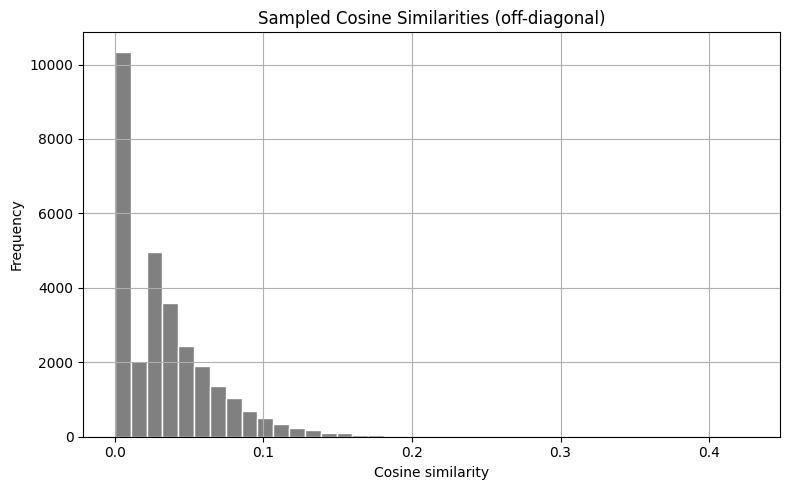

In [19]:
# Sample a subset of similarity scores (excluding diagonal)
np.random.seed(42)
n = min(30000, similarity.size - len(df))  # limit for speed
rows = np.random.randint(0, len(df), size=n)
cols = np.random.randint(0, len(df), size=n)
mask = rows != cols
samp = similarity[rows[mask], cols[mask]]

plt.figure()
pd.Series(samp).plot(kind='hist', bins=40, color = "grey", edgecolor= "white")
plt.title('Sampled Cosine Similarities (off-diagonal)')
plt.xlabel('Cosine similarity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 11) Recommender API

Use `recommend(title, n=10)` to get the **top-n similar movies**. The lookup is case-insensitive; if an exact match isn't found, we provide the closest options.


In [20]:
from difflib import get_close_matches

title_to_index = {t: i for i, t in enumerate(df['title_clean'])}

def recommend(title, n=10, return_scores=False):
    """Return top-n similar movies for a given title.

    Args:
        title (str): Movie title (case-insensitive).
        n (int): Number of recommendations.
        return_scores (bool): If True, include similarity score.

    Returns:
        DataFrame with columns [title, score (optional), genres, overview, vote_average, popularity]
    """
    if not isinstance(title, str) or not title.strip():
        raise ValueError('Provide a non-empty string title.')

    key = title.strip().lower()
    idx = title_to_index.get(key)

    # Fuzzy match if not exact
    if idx is None:
        candidates = get_close_matches(key, list(title_to_index.keys()), n=3, cutoff=0.6)
        if candidates:
            idx = title_to_index[candidates[0]]
            print(f"[Info] Using closest match: '{df.loc[idx, 'title']}' for input '{title}'.")
        else:
            raise ValueError(f"Title '{title}' not found. Try another title.")

    sims = list(enumerate(similarity[idx]))
    sims = sorted(sims, key=lambda x: x[1], reverse=True)

    # Skip the movie itself at position 0
    top = sims[1:n+1]
    rec_idx = [i for i, s in top]
    rec_scores = [s for i, s in top]

    out = df.loc[rec_idx, ['title','genres_list','overview','vote_average','popularity']].copy().reset_index(drop=True)
    if return_scores:
        out.insert(1, 'score', rec_scores)
    return out

# Demo
try:
    display(recommend('Avatar', 5, return_scores=True))
except Exception as e:
    print('[Note] Try running recommend with a title from df["title"].head().tolist() after data loads.')

,title,score,genres_list,overview,vote_average,popularity
0,Titan A.E.,0.25,"[Animation, Action, Science Fiction, Family, Adventure]","A young man finds out that he holds the key to restoring hope and ensuring survival for the human race, while an ali...",6.30,14.44
1,Lifeforce,0.22,"[Fantasy, Horror, Science Fiction, Thriller]",A space shuttle mission investigating Halley's Comet brings back a malevolent race of space vampires who transform m...,6.20,12.18
2,Ender's Game,0.22,"[Science Fiction, Action, Adventure]","Based on the classic novel by Orson Scott Card, Ender's Game is the story of the Earth's most gifted children traini...",6.60,45.95
3,Aliens vs Predator: Requiem,0.22,"[Fantasy, Action, Science Fiction, Thriller, Horror]","A sequel to 2004's Alien vs. Predator, the iconic creatures from two of the scariest film franchises in movie histor...",4.90,39.38
4,Independence Day,0.21,"[Action, Adventure, Science Fiction]","On July 2, a giant alien mothership enters orbit around Earth and deploys several dozen saucer-shaped 'destroyer' sp...",6.70,60.44
